# Streamlines and velocity fields for axis-symmetric bubbles

Three bubbles are investigated:
- dimpled ellipsoidal $Eo=243$, $Mo=266$, $Ga^\prime=15.24$
- spherical cap (closed wake) $Eo=115$, $Mo=4.63\times 10^{-3}$, $Ga^\prime = 135$
- a $d_{eq}=1.8~mm$ bubble rising in water at 20°C, $Eo=0.4361$, $Mo=2.5728\times 10^{-11}$, $Ga^\prime = 238.29$
  
The velocity fields are extracted from the Basilisk simulations using Paraview. The steps are:

- open the right time step: note that there is in offset of 1 between the time displayed in paraview and the physical time because the output files start at t=1 (the physical time t=0 will be displayed as t=0 in paraview)
- transform filter: rotate 90° around z axis to swap x and y axis
- reflect filter: reflect at *X Max* and copy the input (checkbox *Copy Input*)
- cell centers filter
- go to *File* -> *Save Data ...*; select a file name; set the precission to 15 and select *Points* as field association; save

In [2]:
import helper_module as hm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

data_path = "../data/"
files = ["wa18_l16_vel_t20.csv", "scap_l16_vel_t50.csv", "dell_l17_vel_t50.csv"]
for i, file in enumerate(files):
    print(i, data_path + file)

0 ../data/wa18_l16_vel_t20.csv
1 ../data/scap_l16_vel_t50.csv
2 ../data/dell_l17_vel_t50.csv


In [9]:
times = [20, 50, 50] # Basilisk simulation time
Ga = [238.287, 134.626, 15.2400]
U_b = []

all_fields = {}
for i, file in enumerate(files):
    case_name = file.split("_vel")[0]
    log_path = data_path + case_name + "/log." + case_name + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'u_x', 'x'])
    row = log.find_closest("time", times[i])
    U_b.append(row.u_x.values[0])
    field_path = data_path + file
    all_fields[case_name] = hm.CenterFieldValues2D(field_path, [0.0, row.x.values[0]], [0.0, row.u_x.values[0]])
    
print("\nRise velocities:\n")
for key, U in zip(all_fields.keys(), U_b): print(key, U)

Successfully read file ../data/wa18_l16/log.wa18_l16.csv
Successfully read file ../data/wa18_l16_vel_t20.csv
Successfully read file ../data/scap_l16/log.scap_l16.csv
Successfully read file ../data/scap_l16_vel_t50.csv
Successfully read file ../data/dell_l17/log.dell_l17.csv
Successfully read file ../data/dell_l17_vel_t50.csv

Rise velocities:

wa18_l16 2.76881841
scap_l16 0.80718755
dell_l17 0.55113413


In [10]:
# additional plot settings
nx = 200
ny = 400

output_path = "../output/"

def savefig(name):
    plt.savefig(output_path + name + ".png", bbox_inches="tight")
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")

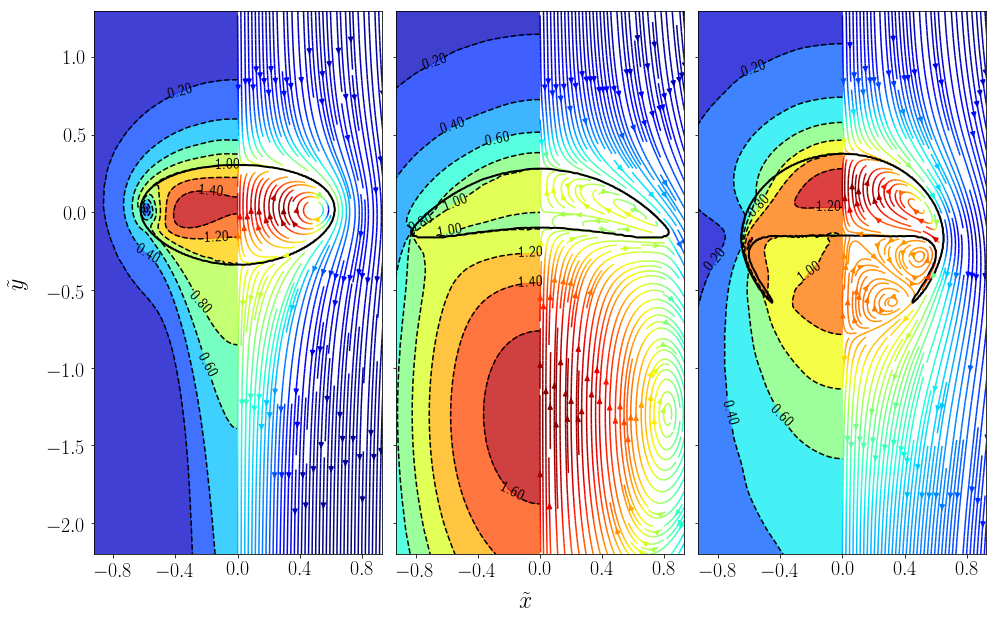

In [16]:
rc('text', usetex=True)

fig, axarr = plt.subplots(1, 3, sharey=True, figsize=(hm.figure_width, 10))

xi_right = np.linspace(0.0, 1.0, nx)
xi_left = np.linspace(-1.0, 0.0, nx)
xi_full = np.linspace(-1.0, 1.0, 2*nx)
yi = np.linspace(-2.2, 1.3, ny)
Xi_left, Yi_left = np.meshgrid(xi_left, yi)
Xi_right, Yi_right = np.meshgrid(xi_right, yi)
Xi_full, Yi_full = np.meshgrid(xi_full, yi)

# bhaga
contours = []
for i, name in enumerate(all_fields.keys()):
    mag_U = all_fields[name].interpolate_velocity(Xi_left, Yi_left)
    U_x, U_y = all_fields[name].interpolate_velocity(Xi_right, Yi_right, True, False)
    vol_f =  all_fields[name].interpolate_volume_fraction(Xi_full, Yi_full)

    axarr[i].contourf(xi_left, yi, mag_U/U_b[i], cmap='jet', alpha=hm.alpha_contour)
    contours.append(axarr[i].contour(xi_left, yi, mag_U/U_b[i], colors='k'))
    axarr[i].clabel(contours[-1], inline=True, fontsize=hm.fontsize_contour, fmt='%1.2f')
    axarr[i].streamplot(Xi_right, Yi_right, U_x, U_y, color=mag_U[:,::-1]/U_b[i], cmap='jet', density=(1.5, 3.0), minlength=0.1, maxlength=8.0)
    axarr[i].contour(xi_full, yi, vol_f, levels=[0.5], colors=['k'], linewidths=2.0)

for ax in axarr:
    ax.axis('equal')
    ax.label_outer()
    ax.set_xticks([-0.8,-0.4, 0.0, 0.4, 0.8])
    ax.tick_params(labelsize=hm.fontsize_tick)

for contour in contours:
    for line in contour.collections:
        line.set_linestyle('dashed')

fig.subplots_adjust(wspace=0.05)
fig.text(0.5, 0.05, r"$\tilde{x}$", ha='center', fontsize=hm.fontsize_label)
fig.text(0.05, 0.5, r"$\tilde{y}$", va='center', rotation='vertical', fontsize=hm.fontsize_label)

savefig("velocity_fields")